# Exponent to Time Domain Comparisons

This notebook compares methods that estimate the aperiodic exponent to time domain methods. 

Frequency Domain Methods:
- Spectral Parameterization

Time Domain Methods:
- Hurst Exponent
- Detrended Fluctation Analysis
- Hjorth complexity
- Lempel Ziv complexity
- Higuchi Fractal Dimension
- Sample Entropy
- Permutation Entropy
- Approximate Entropy
- Spectral Entropy

In [1]:
import numpy as np

from neurodsp.sim import sim_combined
from neurodsp.utils import set_random_seed

In [3]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.io import APMDB
from apm.run import run_comparisons
from apm.analysis import compute_all_corrs
from apm.plts import plot_dots
from apm.plts.utils import make_axes
from apm.plts.settings import COLORS
from apm.methods import (specparam, hurst, dfa, higuchi_fd,
                         hjorth_activity, hjorth_mobility, hjorth_complexity, lempelziv,
                         sample_entropy, perm_entropy, app_entropy, spectral_entropy)
from apm.methods.settings import (HURST_PARAMS, DFA_PARAMS,
                                  AP_ENT_PARAMS, SA_ENT_PARAMS,
                                  PE_ENT_PARAMS, SP_ENT_PARAMS)
from apm.sim.settings import FS, SIM_PARAMS_COMB
from apm.sim.params import sampler
from apm.utils import format_corr

In [2]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [4]:
# Set the random seed
set_random_seed(111)

In [5]:
# Define settings
f_range = [1, 50]
specparam_kwargs = {'min_peak_height' : 0.05, 'fs' : FS, 'f_range' : f_range}

In [6]:
# Settings for running comparisons
RETURN_SIM_PARAMS = True

In [7]:
# Settings for saving figures
SAVE_FIG = False
EXT = '.pdf'
FIGPATH = APMDB().figs_path / '23_exp_time_comp'

## Collect Methods

In [8]:
# Define ranges to sample parameters from
samplers = {'update_comb_exp' : sampler(np.arange(-2.5, 0.1, 0.1)),
            'update_pow' : sampler(np.arange(0, 1.1, 0.1), probs = [0.30] + ([0.07] * 10)),
            'update_freq' : sampler(np.arange(5, 36, 1))}

In [9]:
# Define measures to apply
measures = {specparam : specparam_kwargs,
            hurst : HURST_PARAMS,
            dfa : DFA_PARAMS,
            hjorth_complexity : {}, 
            lempelziv : {},
            higuchi_fd : {},
            app_entropy : AP_ENT_PARAMS,
            perm_entropy : PE_ENT_PARAMS,
            sample_entropy : SA_ENT_PARAMS,
            spectral_entropy : SP_ENT_PARAMS}

## Run Simulations

In [10]:
N_SIMS = 1000

In [11]:
# Run simulations
outputs, all_sim_params = run_comparisons(\
    sim_combined, SIM_PARAMS_COMB, measures, samplers, N_SIMS, RETURN_SIM_PARAMS)

In [12]:
# Set a marker in dataframe for yes / no if signal has an oscillation
all_sim_params['has_osc'] = all_sim_params['var_pe'] != 0.

In [13]:
# Compute correlations across all measures
all_corrs = compute_all_corrs(outputs)

In [14]:
# Compute correlations specific to with & without oscillations
all_corrs_osc = compute_all_corrs(outputs, all_sim_params['has_osc'].values)
all_corrs_no_osc = compute_all_corrs(outputs, ~all_sim_params['has_osc'].values)

### Set up plotting things

In [15]:
# Collect colors for each value based on presence of an oscillation
colors = [COLORS['CM'] if osc else COLORS['AP'] for osc in all_sim_params.has_osc]

In [25]:
# Collect together info & plot settings 
dot_kwargs = {'s' : 16, 'c' : colors, 'alpha' : 0.25}

## Exponent to Fluctuations

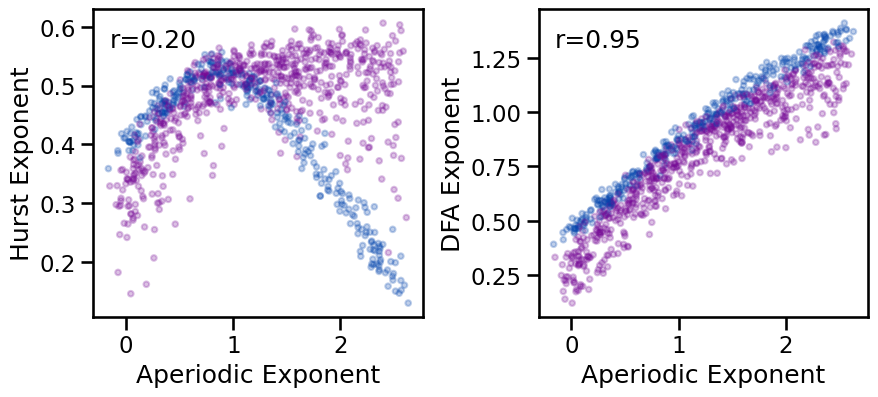

In [26]:
# Plot comparisons
axes = make_axes(1, 2, figsize=(10, 4), wspace=0.35)
plot_dots(outputs['specparam'], outputs['hurst'], tposition='tl', **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='Hurst Exponent', ax=axes[0])
plot_dots(outputs['specparam'], outputs['dfa'], tposition='tl', **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='DFA Exponent', ax=axes[1])
if SAVE_FIG: plt.savefig(FIGPATH / ('exp_fluc_comp' + EXT))

In [27]:
print('Correlations:')
print('  EXP & HST:  ', format_corr(*all_corrs['specparam']['hurst']))
print('  EXP & DFA:  ', format_corr(*all_corrs['specparam']['dfa']))

Correlations:
  EXP & HST:   r=+0.197  CI[+0.121, +0.271],  p=0.000
  EXP & DFA:   r=+0.947  CI[+0.939, +0.954],  p=0.000


## Exponent to Complexity

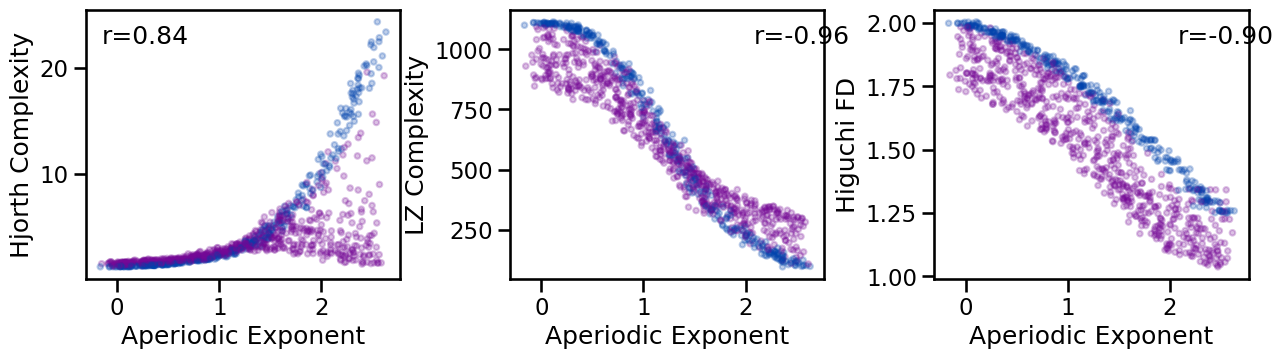

In [28]:
# Plot comparisons
axes = make_axes(1, 3, figsize=[15, 3.5], wspace=0.35)
plot_dots(outputs['specparam'], outputs['hjorth_complexity'], tposition='tl', **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='Hjorth Complexity', ax=axes[0])
plot_dots(outputs['specparam'], outputs['lempelziv'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='LZ Complexity', ax=axes[1])
plot_dots(outputs['specparam'], outputs['higuchi_fd'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='Higuchi FD', ax=axes[2])
if SAVE_FIG: plt.savefig(FIGPATH / ('exp_compl_comp' + EXT))

In [29]:
print('Correlations:')
print('  EXP & HJO:  ', format_corr(*all_corrs['specparam']['hjorth_complexity']))
print('  EXP & LZC:  ', format_corr(*all_corrs['specparam']['lempelziv']))
print('  EXP & HFD:  ', format_corr(*all_corrs['specparam']['higuchi_fd']))

Correlations:
  EXP & HJO:   r=+0.843  CI[+0.809, +0.873],  p=0.000
  EXP & LZC:   r=-0.958  CI[-0.963, -0.951],  p=0.000
  EXP & HFD:   r=-0.901  CI[-0.909, -0.892],  p=0.000


## Exponent to Entropy

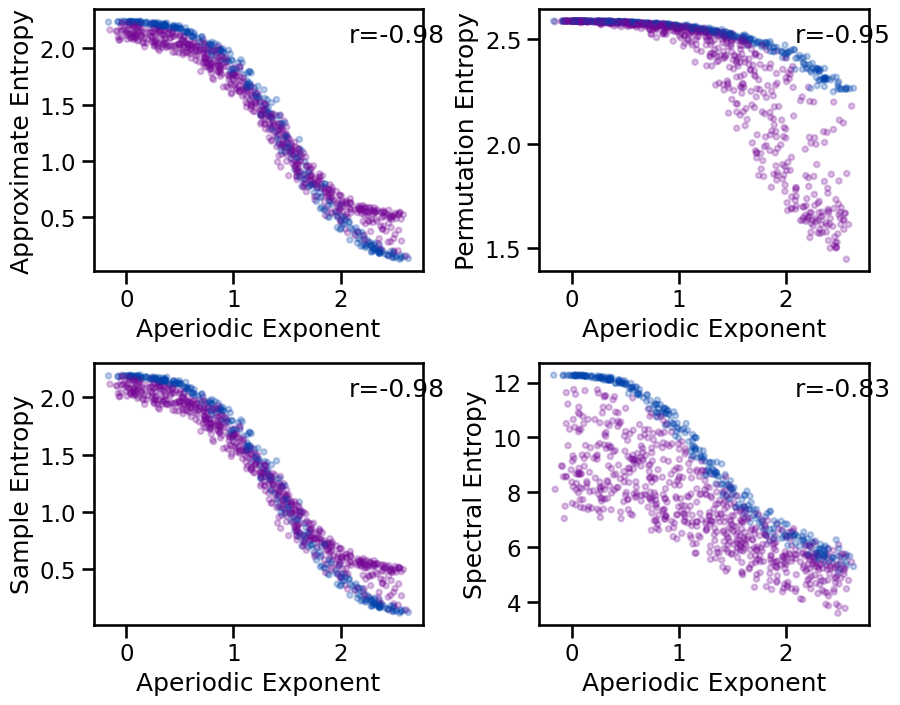

In [30]:
# Plot comparisons
axes = make_axes(2, 2, figsize=[10, 8], wspace=0.35, hspace=0.35)
plot_dots(outputs['specparam'], outputs['app_entropy'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='Approximate Entropy', ax=axes[0, 0])
plot_dots(outputs['specparam'], outputs['perm_entropy'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='Permutation Entropy', ax=axes[0, 1])
plot_dots(outputs['specparam'], outputs['sample_entropy'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='Sample Entropy', ax=axes[1, 0])
plot_dots(outputs['specparam'], outputs['spectral_entropy'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='Spectral Entropy', ax=axes[1, 1])
if SAVE_FIG: plt.savefig(FIGPATH / ('exp_info_comp' + EXT))

In [31]:
print('Correlations:')
print('  EXP & APPR:  ', format_corr(*all_corrs['specparam']['app_entropy']))
print('  EXP & PERM:  ', format_corr(*all_corrs['specparam']['perm_entropy']))
print('  EXP & SAMP:  ', format_corr(*all_corrs['specparam']['sample_entropy']))
print('  EXP & SPCT:  ', format_corr(*all_corrs['specparam']['spectral_entropy']))

Correlations:
  EXP & APPR:   r=-0.978  CI[-0.981, -0.974],  p=0.000
  EXP & PERM:   r=-0.954  CI[-0.960, -0.947],  p=0.000
  EXP & SAMP:   r=-0.978  CI[-0.981, -0.974],  p=0.000
  EXP & SPCT:   r=-0.834  CI[-0.851, -0.815],  p=0.000


## Conclusions

Comparing between these methods, overall we can see that:
- Hurst and DFA exponent generally increase with increasing aperiodic exponent
- Hjorth complexity increases, but lempel-ziv and higuchi fractal dimension decrease, with increasing exponent
- Entropy measures generally decrease with increasing exponent